In [1]:
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from sklearn import linear_model, preprocessing
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score

from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

In [2]:
def parseData(row):
    return datetime.strptime(row['Data'], "%Y-%m-%d")

def getCity(city, cities):
    dataframe = cities[cities['City'] == city]
    dataframe = dataframe[['16-06', '22-06', '29-06', '06-07', '13-07', '20-07', '10-08', '18-08', '24-08', '01-09', '07-09', '15-09', '21-09']]
    return dataframe.sum()

def groupCovid(df, start, end):
    df = df.sort_values(by="Data")
    df = df[(df['Data'] >= start) & (df['Data'] <= end)]
    
    groupedByWeek = df.groupby(df['Data'].dt.strftime('%W'))['casos']
    
    return groupedByWeek.sum()

def analyzeCity(cityAnalyzed, weeksAfter):
    covid = pd.read_csv('../data/casos/covid-cases.csv')

    #remover colunas unamed
    covid.drop(covid.columns[covid.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    covid['Data'] = covid.apply (lambda row: parseData(row), axis=1)
    df = covid[covid['cidade'] == cityAnalyzed]
    cities = pd.read_csv('../data/distribuicao-tweets/distribuitionWithCity.csv')

    tweetsNormalizados = getCity(cityAnalyzed, cities)

    #normaliza dados
    tweetsNormalizados=(tweetsNormalizados-tweetsNormalizados.min())/(tweetsNormalizados.max()-tweetsNormalizados.min())
    covidDataByWeek = groupCovid(df, "2020-06-30", "2020-09-21")

    #normaliza dados
    covidDataByWeek=(covidDataByWeek-covidDataByWeek.min())/(covidDataByWeek.max()-covidDataByWeek.min())
    dfTweets = pd.DataFrame({'data':tweetsNormalizados.index, 'tweets na semana':tweetsNormalizados.values})
    dfTweets["id"] = dfTweets.index

    dfCasos = pd.DataFrame({'semana':covidDataByWeek.index, 'casos de covid na semana':covidDataByWeek.values})
    dfCasos["id"] = dfCasos.index + weeksAfter #compara com casos X semanas seguintes
    
    dadosAgrupados = pd.concat([dfTweets])
    dadosAgrupados = pd.merge(dadosAgrupados, dfCasos, on='id')
    dadosAgrupados = dadosAgrupados[['data', 'semana', 'tweets na semana', 'casos de covid na semana']]

    return dadosAgrupados 

In [3]:
def generate_data(city, weeks):
  df = analyzeCity(city, weeks)

  x_data = []
  tweets = np.array(df['tweets na semana'])

  i = 0
  for week in np.array(pd.to_numeric(df['semana'])):
    x_data.append([week, tweets[i]])
    i += 1

  y_data = np.array(df['casos de covid na semana'])

  return x_data, y_data

def generate_linear_model(city, weeks):
  x_data, y_data = generate_data(city, weeks)

  reg = linear_model.LinearRegression().fit(x_data, y_data)
  print(f"Regressão linear {city}. score: {reg.score(x_data, y_data)}")

  return reg, reg.score(x_data, y_data)

- São Paulo - casos de 4 semanas depois refletem os tweets dessa semana com 0.692619 corr
- Rio de Janeiro - casos de 4 semanas depois refletem os tweets dessa semana com -0.604875 corr
- Belo Horizonte - casos de 1 semana depois refletem os tweets dessa semana com 0.61064 corr
- Fortaleza - casos de 2 semanas depois refletem os tweets dessa semana com 0.631897 corr
- Porto Alegre - casos de 3 semanas depois refletem os tweets dessa semana com -0.617216 corr
- Recife - casos de 3 semanas depois refletem os tweets dessa semana com 0.579416 corr
- Manaus - casos de 4 semanas depois refletem os tweets dessa semana com -0.408583 corr
- Salvador - casos de 2 semanas depois refletem os tweets dessa semana com -0.326249 corr

In [4]:
sp, sp_score = generate_linear_model("São Paulo", 4)
rj, rj_score = generate_linear_model("Rio de Janeiro", 4)
bh, bh_score = generate_linear_model("Belo Horizonte", 1)
fl, fl_score = generate_linear_model("Fortaleza", 2)
pa, pa_score = generate_linear_model("Porto Alegre", 3)
rc, rc_score = generate_linear_model("Recife", 3)
mn, mn_score = generate_linear_model("Manaus", 4)
sv, sv_score = generate_linear_model("Salvador", 2)

Regressão linear São Paulo. score: 0.5459098529385663
Regressão linear Rio de Janeiro. score: 0.39575466785585944
Regressão linear Belo Horizonte. score: 0.3811011382790829
Regressão linear Fortaleza. score: 0.7355593718195894
Regressão linear Porto Alegre. score: 0.3974940886990981
Regressão linear Recife. score: 0.41375832064962315
Regressão linear Manaus. score: 0.5544018137232916
Regressão linear Salvador. score: 0.4464702774569249


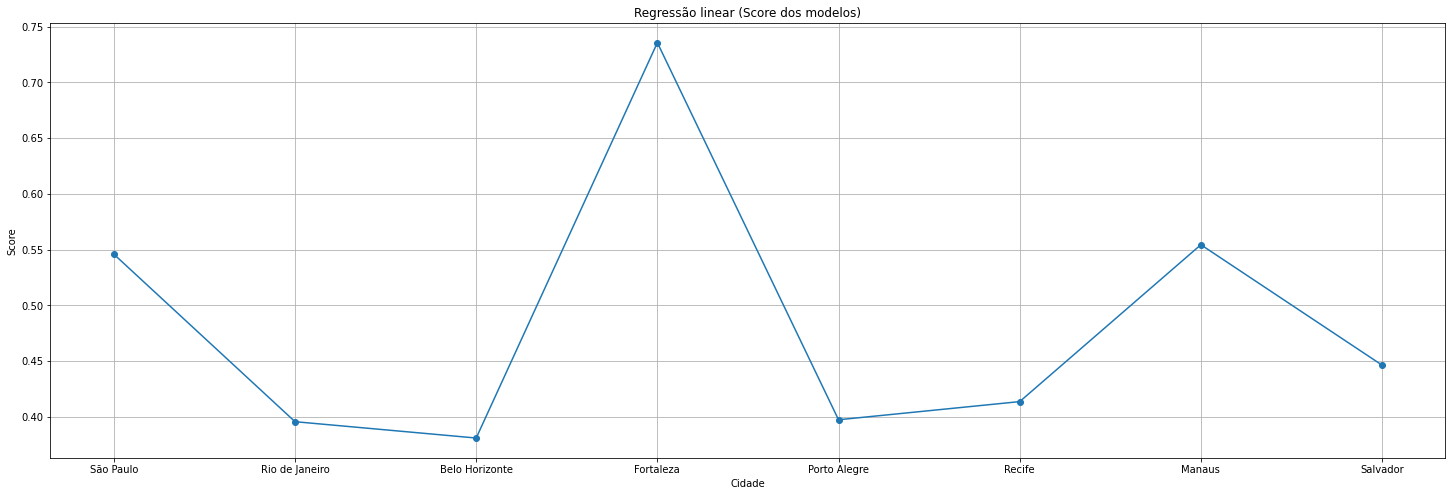

In [5]:
x = ["São Paulo", "Rio de Janeiro", "Belo Horizonte", "Fortaleza", "Porto Alegre", "Recife", "Manaus", "Salvador"]
y = [sp_score, rj_score, bh_score, fl_score, pa_score, rc_score, mn_score, sv_score]

fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(x, y, marker='o')

ax.set(xlabel='Cidade', ylabel='Score', title='Regressão linear (Score dos modelos)')
ax.grid()

plt.show()

In [6]:
#teste pontual para tentativa de próximas semanas
sp.predict(np.array([[35, 0.05]]))

array([0.66768648])

In [7]:
def generate_exp_model(city, weeks):
    def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
        return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(x_data, *parameterTuple)
        return np.sum((y_data - val) ** 2.0)


    def generate_Initial_Parameters():
        # min and max used for bounds
        maxX = max(x_data)
        minX = min(x_data)
        maxY = max(y_data)
        minY = min(y_data)

        parameterBounds = []
        parameterBounds.append([minX, maxX]) # search bounds for a
        parameterBounds.append([minX, maxX]) # search bounds for b
        parameterBounds.append([0.0, maxY]) # search bounds for Offset

        # "seed" the np random number generator for repeatable results
        result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
        return result.x

    # graphics output section
    def ModelAndScatterPlot(graphWidth, graphHeight, fittedParameters, RMSE, Rsquared, city):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
        axes = f.add_subplot(111)

        # first the raw data as a scatter plot
        axes.plot(x_data, y_data, 'D')

        # create data for the fitted equation plot
        xModel = np.linspace(min(x_data), max(x_data))
        yModel = func(xModel, *fittedParameters)

        # now the model as a line plot 
        axes.plot(xModel, yModel)

        axes.set_xlabel('Tweets na semana') # X axis data label
        axes.set_ylabel('Casos de covid na semana') # Y axis data label
        axes.set_title(f'Curva encontrada - {city}')
        plt.text(-0.05, 0.2, f'Parâmetros: {str(fittedParameters)}\nRMSE: {str(RMSE)}\nR^2: {str(Rsquared)}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='red', alpha=0.5))

        plt.show()
        plt.close('all') # clean up after using pyplot

    df = analyzeCity(city, weeks)

    x_data = np.array(df['tweets na semana'])
    y_data = np.array(df['casos de covid na semana'])

    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters()

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, x_data, y_data, geneticParameters)

    print('Parameters', fittedParameters)

    modelPredictions = func(x_data, *fittedParameters) 

    absError = modelPredictions - y_data

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(y_data))

    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    graphWidth = 800
    graphHeight = 600
    ModelAndScatterPlot(graphWidth, graphHeight, fittedParameters, RMSE, Rsquared, city)
    return Rsquared


Parameters [ 5.09123963 -0.02499038 -0.01583448]
RMSE: 0.12159249524142685
R-squared: 0.49207370610572154


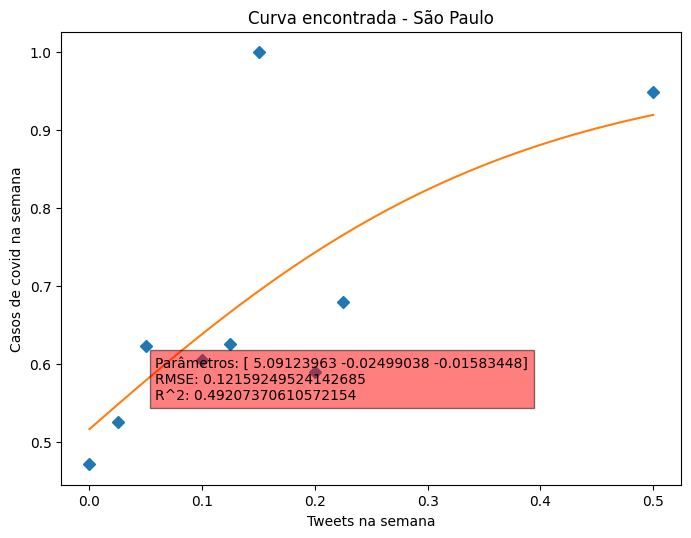

Parameters [-10.52629292   0.01735313   0.43908794]
RMSE: 0.13466295380415355
R-squared: 0.6369917661042885


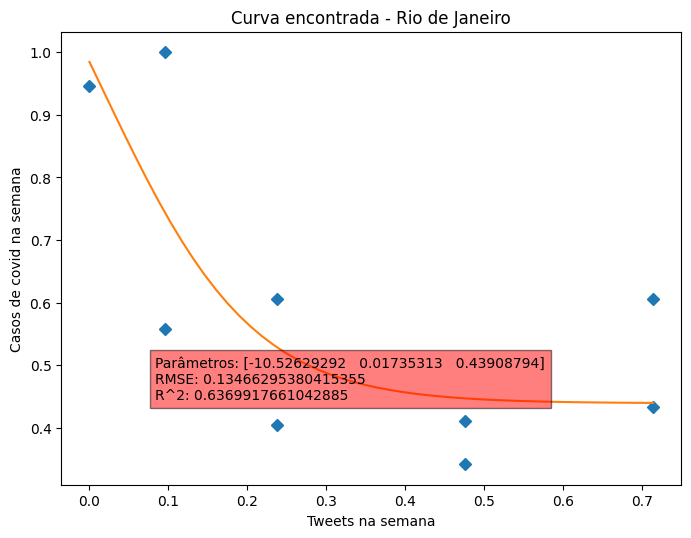

Parameters [ 2.02194166 -0.02363137  0.01710422]
RMSE: 0.13106566081411147
R-squared: 0.38049561710335345


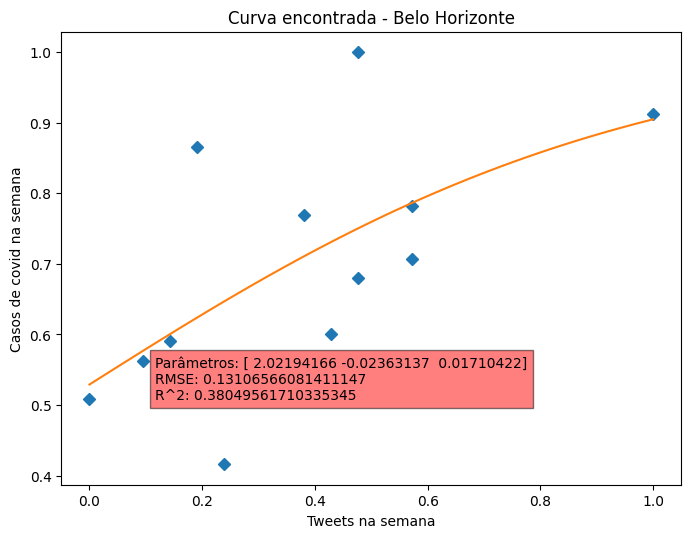

Parameters [ 2.84522666 -0.00395445 -0.09892708]
RMSE: 0.18318548743249818
R-squared: 0.41589174691184216


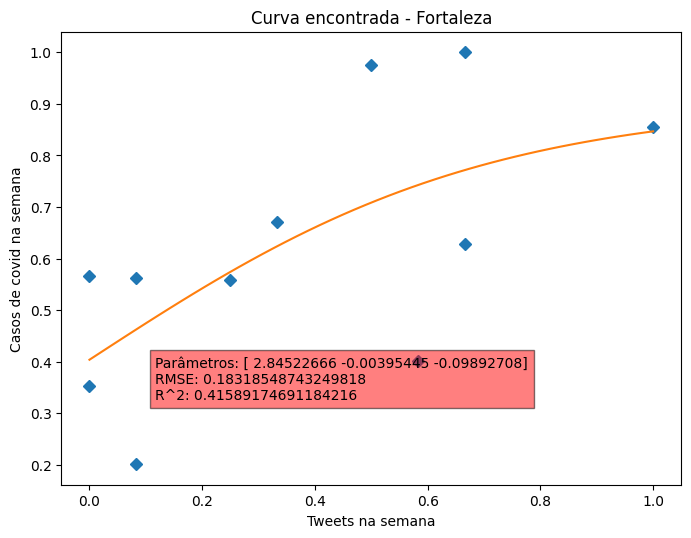

Parameters [-39.02287885   0.04968111   0.12524734]
RMSE: 0.047088399722368224
R-squared: 0.9694073236161737


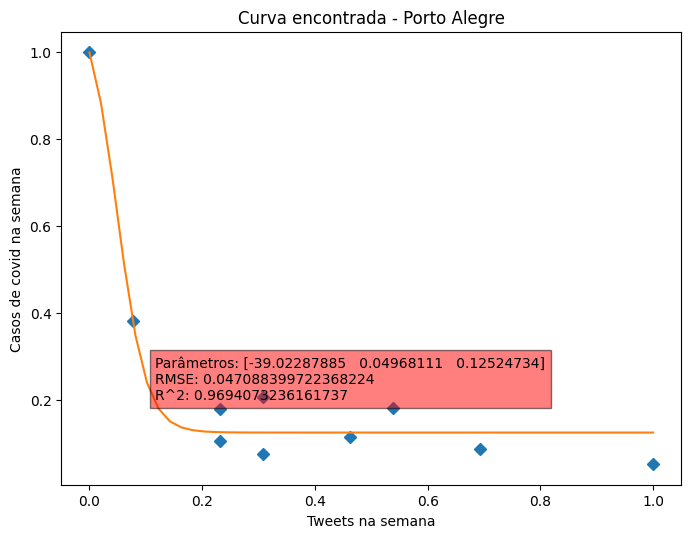

Parameters [ 2.82545332e+01 -3.37430051e-03 -1.65017200e-01]
RMSE: 0.183814492994569
R-squared: 0.5113553719349955


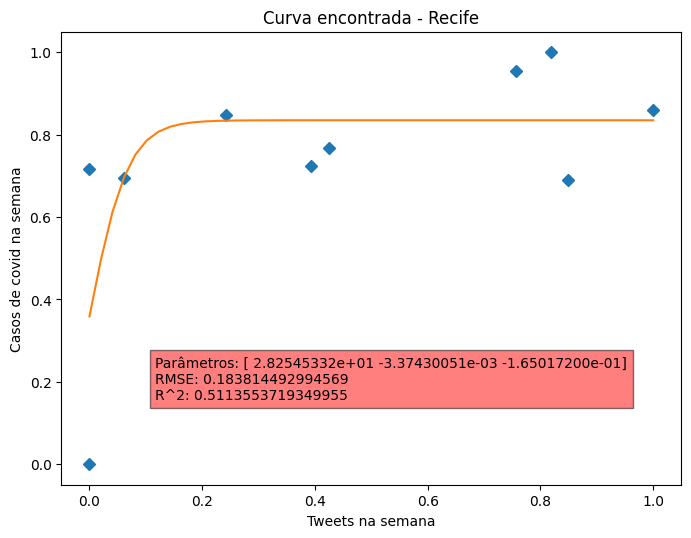

Parameters [-28.78319516  -0.06531213   0.60384453]
RMSE: 0.12435328817517459
R-squared: 0.2012219284624509


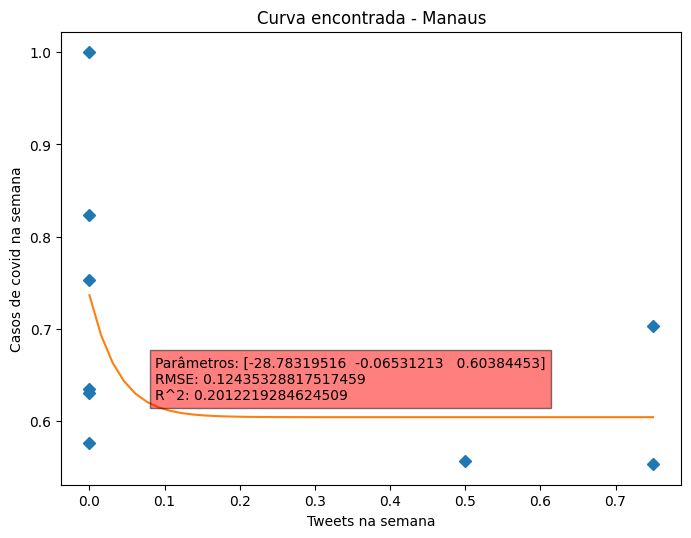

Parameters [-96.79070425   0.68208682  -0.20921414]
RMSE: 0.1566896757737194
R-squared: 0.4049951941211174


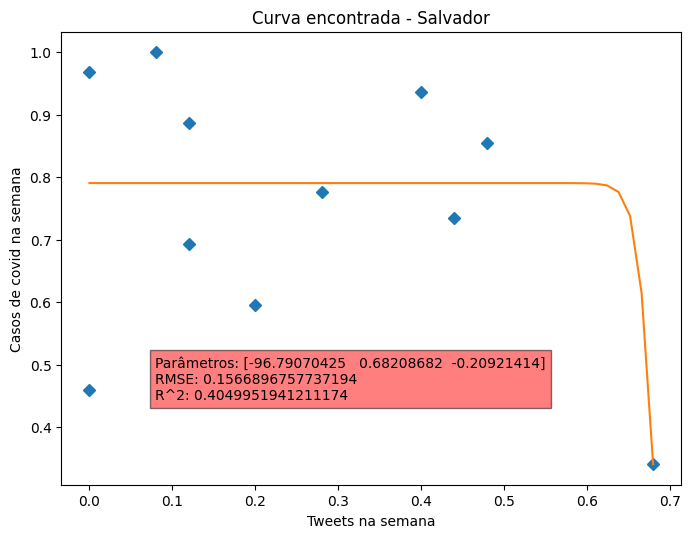

In [8]:
sp_exp = generate_exp_model("São Paulo", 4)
rj_exp = generate_exp_model("Rio de Janeiro", 4)
bh_exp = generate_exp_model("Belo Horizonte", 1)
fl_exp = generate_exp_model("Fortaleza", 2)
pa_exp = generate_exp_model("Porto Alegre", 3)
rc_exp = generate_exp_model("Recife", 3)
mn_exp = generate_exp_model("Manaus", 4)
sv_exp = generate_exp_model("Salvador", 2)

y_exp = [sp_exp, rj_exp, bh_exp, fl_exp, pa_exp, rc_exp, mn_exp, sv_exp]

In [9]:
def generate_logistic_model(city, weeks):
  x_data, y_data = generate_data(city, weeks)

  lab_enc = preprocessing.LabelEncoder()
  y_data = lab_enc.fit_transform(y_data)

  reg = linear_model.LogisticRegression().fit(x_data, y_data)
  print(f"Regressão logística {city}. score: {reg.score(x_data, y_data)}")

  return reg, reg.score(x_data, y_data)

sp, sp_logistic = generate_logistic_model("São Paulo", 4)
rj, rj_logistic = generate_logistic_model("Rio de Janeiro", 4)
bh, bh_logistic = generate_logistic_model("Belo Horizonte", 1)
fl, fl_logistic = generate_logistic_model("Fortaleza", 2)
pa, pa_logistic = generate_logistic_model("Porto Alegre", 3)
rc, rc_logistic = generate_logistic_model("Recife", 3)
mn, mn_logistic = generate_logistic_model("Manaus", 4)
sv, sv_logistic = generate_logistic_model("Salvador", 2)

Regressão logística São Paulo. score: 0.6666666666666666
Regressão logística Rio de Janeiro. score: 0.7777777777777778
Regressão logística Belo Horizonte. score: 0.75
Regressão logística Fortaleza. score: 0.8181818181818182
Regressão logística Porto Alegre. score: 0.7
Regressão logística Recife. score: 0.8
Regressão logística Manaus. score: 0.7777777777777778
Regressão logística Salvador. score: 0.7272727272727273


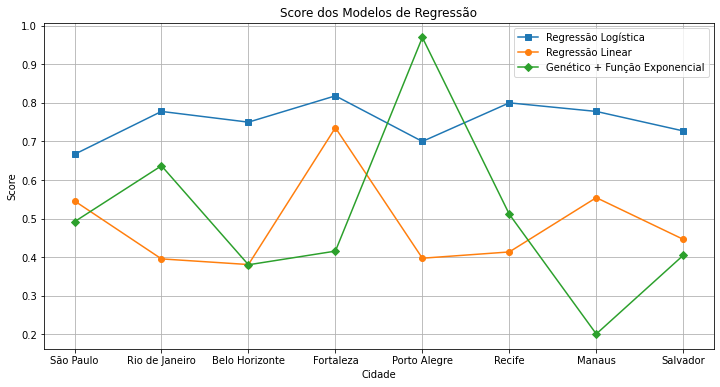

In [13]:
y_logistic = [sp_logistic, rj_logistic, bh_logistic, fl_logistic, pa_logistic, rc_logistic, mn_logistic, sv_logistic]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x, y_logistic, linestyle='', marker='s', label="Regressão Logística")
ax.plot(x, y, linestyle='', marker='o', label="Regressão Linear")
ax.plot(x, y_exp, linestyle='', marker='D', label="Genético + Função Exponencial")

ax.set(xlabel='Cidade', ylabel='Score', title='Score dos Modelos de Regressão')
ax.legend()
ax.grid()

plt.show()

In [11]:
#teste pontual para tentativa de próximas semanas
rj.predict(np.array([[35, 0.05]]))

array([4])